# 人流量计数+足迹追踪

MMtracking 预训练模型库 Model Zoo：https://mmtracking.readthedocs.io/en/latest/model_zoo.html

如果报错`CUDA out of memory.`则重启前面几个代码的`kernel`即可。

作者：同济子豪兄 2022-4-21

## 进入 MMTracking 主目录

In [1]:
import os
os.chdir('mmtracking')
os.listdir()

['.git',
 '.circleci',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_zh-CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmtrack',
 'model-index.yml',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmtrack.egg-info',
 'checkpoints',
 'outputs',
 'data']

## 导入工具包

In [2]:
# 导入 opencv-python
import cv2

import mmcv

import numpy as np

import random

import seaborn as sns

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

import tempfile
from mmtrack.apis import inference_mot, init_model
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

## 人流量计数 + 足迹绘制 详细实现

### 从视频中获取某一帧图像

In [3]:
# 输入输出视频路径
input_video = 'data/mot_people_short.mp4'
output = 'outputs/output_G1_MOT_people_short.mp4'
# 读入视频
imgs = mmcv.VideoReader(input_video)

In [4]:
# 获取视频第i帧画面
frame_id = 0
img = imgs[frame_id]

In [5]:
img.shape

(1080, 1920, 3)

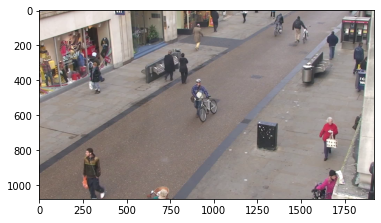

In [6]:
show_img_from_array(img)

### 导入多目标追踪模型

In [7]:
# 指定 config 配置文件 和 模型权重文件，创建模型
mot_config = './configs/mot/bytetrack/bytetrack_yolox_x_crowdhuman_mot17-private-half.py'
mot_checkpoint = 'https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth'
# 初始化模型
mot_model = init_model(mot_config, mot_checkpoint, device='cuda:0')

2022-04-25 14:04:43,738 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2022-04-25 14:04:43,770 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2022-04-25 14:04:43,771 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2022-04-25 14:04:43,773 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2022-04-25 14:04:44,157 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from http path: https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector

### 执行多目标追踪

In [8]:
result = inference_mot(mot_model, img, frame_id=frame_id)

/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/environment/miniconda3/lib/python3.7/site-packages/mmdet/models/dense_heads/yolox_head.py:286: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  scale_factors).unsqueeze(1)


解析多目标追踪 result 结果

### 解析多目标追踪`result`结果

In [9]:
result.keys()

dict_keys(['det_bboxes', 'track_bboxes'])

In [11]:
# result['det_bboxes']

In [12]:
result['det_bboxes'][0][:10]

array([[1.6019095e+03, 6.0782794e+02, 1.7185277e+03, 8.6616089e+02,
        9.4052279e-01],
       [1.6459392e+03, 1.1914110e+02, 1.7179167e+03, 2.8813354e+02,
        9.2666405e-01],
       [1.4493016e+03, 3.2618118e+01, 1.5361381e+03, 1.8836691e+02,
        9.1761655e-01],
       [7.9675891e+02, 2.4251991e+02, 8.5994458e+02, 4.2668658e+02,
        9.1220850e-01],
       [1.3466731e+03, 1.4821764e+01, 1.4049393e+03, 1.3409984e+02,
        9.0926546e-01],
       [8.6739935e+02, 3.8889447e+02, 9.9191016e+02, 6.1932056e+02,
        9.0501010e-01],
       [1.7965985e+03, 1.7947960e+02, 1.8677836e+03, 3.7402744e+02,
        9.0399045e-01],
       [7.1240686e+02, 2.2749742e+02, 7.8477185e+02, 4.1062335e+02,
        8.9260650e-01],
       [8.7765161e+02, 7.5635765e+01, 9.4659149e+02, 2.3703418e+02,
        8.8843852e-01],
       [2.4237114e+02, 7.8445648e+02, 3.8073230e+02, 1.1103938e+03,
        8.8518399e-01]], dtype=float32)

In [13]:
len(result['det_bboxes'][0])

39

In [14]:
len(result['track_bboxes'][0])

17

每个目标检测框的左上角xy坐标、右下角xy坐标、置信度

[0] 表示只看行人类别

ID、左上角x、左上角y、右下角x、右下角y、置信度

[0] 表示只看行人类别

In [15]:
result['track_bboxes'][0]

array([[ 0.00000000e+00,  1.60190955e+03,  6.07827942e+02,
         1.71852771e+03,  8.66160889e+02,  9.40522790e-01],
       [ 1.00000000e+00,  1.64593921e+03,  1.19141098e+02,
         1.71791675e+03,  2.88133545e+02,  9.26664054e-01],
       [ 2.00000000e+00,  1.44930164e+03,  3.26181183e+01,
         1.53613806e+03,  1.88366913e+02,  9.17616546e-01],
       [ 3.00000000e+00,  7.96758911e+02,  2.42519913e+02,
         8.59944580e+02,  4.26686584e+02,  9.12208498e-01],
       [ 4.00000000e+00,  1.34667310e+03,  1.48217640e+01,
         1.40493933e+03,  1.34099838e+02,  9.09265459e-01],
       [ 5.00000000e+00,  8.67399353e+02,  3.88894470e+02,
         9.91910156e+02,  6.19320557e+02,  9.05010104e-01],
       [ 6.00000000e+00,  1.79659851e+03,  1.79479599e+02,
         1.86778357e+03,  3.74027435e+02,  9.03990448e-01],
       [ 7.00000000e+00,  7.12406860e+02,  2.27497421e+02,
         7.84771851e+02,  4.10623352e+02,  8.92606497e-01],
       [ 8.00000000e+00,  8.77651611e+02,  7.563

In [16]:
len(result['track_bboxes'][0])

17

In [17]:
# 当前帧各目标的ID
result['track_bboxes'][0][:,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

### 整理多目标追踪`result`结果

In [18]:
from mmtrack.core import imshow_tracks, results2outs

In [19]:
outs_track = results2outs(bbox_results=result.get('track_bboxes', None))

In [20]:
outs_track

{'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'bboxes': array([[ 1.6019095e+03,  6.0782794e+02,  1.7185277e+03,  8.6616089e+02,
          9.4052279e-01],
        [ 1.6459392e+03,  1.1914110e+02,  1.7179167e+03,  2.8813354e+02,
          9.2666405e-01],
        [ 1.4493016e+03,  3.2618118e+01,  1.5361381e+03,  1.8836691e+02,
          9.1761655e-01],
        [ 7.9675891e+02,  2.4251991e+02,  8.5994458e+02,  4.2668658e+02,
          9.1220850e-01],
        [ 1.3466731e+03,  1.4821764e+01,  1.4049393e+03,  1.3409984e+02,
          9.0926546e-01],
        [ 8.6739935e+02,  3.8889447e+02,  9.9191016e+02,  6.1932056e+02,
          9.0501010e-01],
        [ 1.7965985e+03,  1.7947960e+02,  1.8677836e+03,  3.7402744e+02,
          9.0399045e-01],
        [ 7.1240686e+02,  2.2749742e+02,  7.8477185e+02,  4.1062335e+02,
          8.9260650e-01],
        [ 8.7765161e+02,  7.5635765e+01,  9.4659149e+02,  2.3703418e+02,
          8.8843852e-01],
        [ 2.4237114e+02,  7.

In [21]:
# 取出结果
bboxes = outs_track.get('bboxes', None)
labels = outs_track.get('labels', None)
ids = outs_track.get('ids', None)

In [22]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### 可视化配置-调色板

In [28]:
# 生成调色板
palette = sns.color_palette('hls', 25)

In [29]:
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.496, 0.33999999999999997),
 (0.86, 0.6208, 0.33999999999999997),
 (0.86, 0.7456, 0.33999999999999997),
 (0.8496, 0.86, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.6000000000000001, 0.86, 0.33999999999999997),
 (0.47519999999999996, 0.86, 0.33999999999999997),
 (0.3503999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.4544),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7040000000000001),
 (0.33999999999999997, 0.86, 0.8288),
 (0.33999999999999997, 0.7663999999999997, 0.86),
 (0.33999999999999997, 0.6415999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999999, 0.86),
 (0.33999999999999997, 0.3919999999999998, 0.86),
 (0.4128000000000003, 0.33999999999999997, 0.86),
 (0.5375999999999996, 0.33999999999999997, 0.86),
 (0.6623999999999999, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.808),
 (0.86, 0.33999999999999997, 0.6831999999999999),
 (0.86, 0.33999999999999997, 0.5583999999999998),
 (0.86, 0.33999999999999997, 0.4335999999999997)]

In [30]:
# 从调色板中随机挑选一种颜色
random.seed(3)
bbox_color = random.choice(palette)

In [31]:
bbox_color

(0.47519999999999996, 0.86, 0.33999999999999997)

In [32]:
bbox_color = [int(255 * c) for c in bbox_color][::-1]

In [33]:
bbox_color

[86, 219, 121]

In [34]:
def get_color(seed):
    '''
    传入追踪ID，生成专属颜色
    '''
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

In [35]:
get_color(3)

[86, 219, 121]

### 可视化配置-目标检测矩形框

In [36]:
# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr = 0.0

# 字体大小
font_scale = 0.4

# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

In [37]:
# 目标检测框的 x坐标 不超过图像宽度
bboxes[:, [0,2]] = np.clip(bboxes[:, [0,2]], 0, img.shape[1])
# 目标检测框的 y坐标 不超过图像高度
bboxes[:, [1,3]] = np.clip(bboxes[:, [1,3]], 0, img.shape[0])

In [38]:
# 筛选出目标检测置信度大于指定阈值的目标，并取出其索引、目标检测、类别、ID信息
inds = np.where(bboxes[:, -1] > score_thr)[0]
bboxes = bboxes[inds]
labels = labels[inds]
ids = ids[inds]

In [39]:
# 遍历当前帧中的每个目标，可视化
for i, (bbox, label, id) in enumerate(zip(bboxes, labels, ids)):
    
    # 获取目标检测框的左上角、右下角坐标，及置信度
    x1, y1, x2, y2 = bbox[:4].astype(np.int32)
    score = float(bbox[-1])

    # 绘制目标检测矩形框
    bbox_color = get_color(id)
    cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, thickness=thickness)

    # 置信度文字
    text = '{:.02f}'.format(score)
    if classes is not None: # 类别信息
        text += f'|{classes[label]}'
    # 绘制置信度文字的背景
    width = len(text) * text_width
    img[y1:y1 + text_height, x1:x1 + width, :] = bbox_color
    # 写置信度文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
    cv2.putText(img, text, (x1, y1 + text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

    # 目标 ID 文字
    text = str(id)
    # 绘制 ID 文字的背景
    width = len(text) * text_width
    img[y1 + text_height:y1 + 2 * text_height, x1:x1 + width, :] = bbox_color
    # 写 ID 文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
    cv2.putText(img, str(id), (x1, y1 + 2 * text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

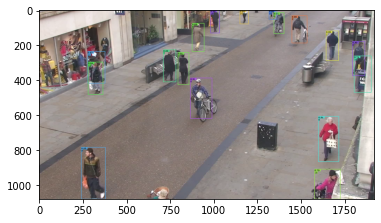

In [40]:
show_img_from_array(img)

## 封装函数-人流量计数+足迹绘制

重启`kernel`，运行下面代码

In [1]:
# 进入 mmtracking 主目录
import os
os.chdir('mmtracking')

In [2]:
# 导入 opencv-python
import cv2

import mmcv

import numpy as np

import random

import seaborn as sns

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
import tempfile
from mmtrack.apis import inference_mot, init_model
from mmtrack.core import imshow_tracks, results2outs
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

def get_color(seed):
    '''
    传入追踪ID，生成专属颜色
    '''
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

In [3]:
from mmtrack.core import imshow_tracks, results2outs

# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr = 0.0

# 字体大小
font_scale = 0.4
 
# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

# 生成调色板
palette = sns.color_palette('hls',30)

# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr=0.0

# 字体大小
font_scale=0.4

# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

In [5]:
def get_color(seed):
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

def process_result(result):
    '''处理单帧函数，输入MOT多目标追踪结果，输出 MOT多目标追踪可视化图像、所有目标轨迹中心点坐标'''

    #######################
    # 整理多目标追踪结果
    #######################
    # 进一步整理result结果
    outs_track = results2outs(bbox_results=result.get('track_bboxes', None))

    # 取出结果
    bboxes = outs_track.get('bboxes', None)
    labels = outs_track.get('labels', None)
    ids = outs_track.get('ids', None)

    # 目标检测框的 x坐标 不超过图像宽度
    bboxes[:, [0,2]] = np.clip(bboxes[:, [0,2]], 0, img.shape[1])
    # 目标检测框的 y坐标 不超过图像高度
    bboxes[:, [1,3]] = np.clip(bboxes[:, [1,3]], 0, img.shape[0])

    # 筛选出目标检测置信度大于指定阈值的目标，并取出其索引、目标检测、类别、ID信息
    inds = np.where(bboxes[:, -1] > score_thr)[0]
    bboxes = bboxes[inds]
    labels = labels[inds]
    ids = ids[inds]

    #######################
    # 遍历每个目标，可视化
    #######################
    trace_coords_frame = [] # 存放当前帧画面中 所有目标轨迹中心点坐标
    for i, (bbox, label, id) in enumerate(zip(bboxes, labels, ids)):
        # 获取目标检测框的左上角、右下角坐标，及置信度
        x1, y1, x2, y2 = bbox[:4].astype(np.int32)
        score = float(bbox[-1])

        # 绘制目标检测矩形框
        bbox_color = get_color(id)
        cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, thickness=thickness)

        # 绘制矩形框中心点轨迹点，指定圆心坐标和半径，红色，最后一个参数为线宽，-1表示填充
        # trace_coord = {id:[[(x1+x2)//2, (y1+y2)//2], bbox_color]}
        # trace_coord_obj = [id, [(x1+x2)//2, (y1+y2)//2, bbox_color]] # 目标检测框中心点作为轨迹点
        trace_coord_obj = [id, [(x1+x2)//2, y2, bbox_color]]           # 目标检测框底边中点作为轨迹点
        trace_coords_frame.append(trace_coord_obj)
        
        # 置信度文字
        text = '{:.02f}'.format(score)
        if classes is not None: # 类别信息
            text += f'|{classes[label]}'
        # 绘制置信度文字的背景
        width = len(text) * text_width
        img[y1:y1 + text_height, x1:x1 + width, :] = bbox_color
        # 写置信度文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
        cv2.putText(img, text, (x1, y1 + text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

        # ID
        text = str(id)
        # 绘制ID文字的背景
        width = len(text) * text_width
        img[y1 + text_height:y1 + 2 * text_height, x1:x1 + width, :] = bbox_color
        # 写 ID文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
        cv2.putText(img, str(id), (x1, y1 + 2 * text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

    return img, trace_coords_frame

## 人流量计数+足迹绘制，视频结果生成

In [6]:
# 输入输出视频路径
input_video = 'data/mot_people_short.mp4'
output = 'outputs/G1_MOT_people_short.mp4'

## ByteTrack算法
# 指定 config 配置文件 和 模型权重文件，创建模型
mot_config = './configs/mot/bytetrack/bytetrack_yolox_x_crowdhuman_mot17-private-half.py'
mot_checkpoint = 'https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth'
# 初始化模型
mot_model = init_model(mot_config, mot_checkpoint, device='cuda:0')

## Deepsort算法
# # 指定 config 配置文件 和 模型权重文件，创建模型
# mot_config = './configs/mot/deepsort/deepsort_faster-rcnn_fpn_4e_mot17-private-half.py'
# # 初始化模型
# mot_model = init_model(mot_config, device='cuda:0')

2022-04-25 14:13:24,942 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2022-04-25 14:13:24,975 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2022-04-25 14:13:24,976 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2022-04-25 14:13:24,977 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2022-04-25 14:13:25,354 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from http path: https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector

In [7]:
# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmcv.ProgressBar(len(imgs))
out_dir = tempfile.TemporaryDirectory()
out_path = out_dir.name

# 人数计数
num = 0

# 记录每一帧的各目标轨迹点坐标
trace_coord_video = []

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    #######################
    # 运行多目标追踪
    #######################
    result = inference_mot(mot_model, img, frame_id=frame_id)
    
    # 获取当前帧目标检测可视化效果，及各目标轨迹点坐标
    img, trace_coord_frame = process_result(result)
    trace_coord_video.append(trace_coord_frame)
    
    #######################
    # 绘制轨迹点：从第一帧到当前帧 所有目标的轨迹点
    #######################
    for trace_coord_frame in trace_coord_video: # 遍历每一帧
        for trace_coord_obj in trace_coord_frame: # 遍历每一个目标
            # 绘制圆，指定圆心坐标和半径，颜色，最后一个参数为线宽，-1表示填充
            cv2.circle(img, (trace_coord_obj[1][0], trace_coord_obj[1][1]),5, trace_coord_obj[1][2], -1)
    
    #######################
    #  获取人数
    #######################
    # 用当前最大的 ID 号作为人数值
    if result['track_bboxes'][0][:,0].any(): # 检测出行人
        num = max(num, 1+max(result['track_bboxes'][0][:,0]))
    else: # 没有检测出行人
        num = num
    
    # 可视化总人数：图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
    img = cv2.putText(img, str(int(num)), (25, 150), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 255), 3)
    # 可视化当前人数
    img = cv2.putText(img, str(len(trace_coord_frame)), (25, 350), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 3)

    # 将处理后的该帧画面图像文件，保存至 /tmp 目录下
    cv2.imwrite(f'{out_path}/{frame_id:06d}.jpg', img)

    # 更新进度条
    prog_bar.update()

# 由每一帧的图像文件，生成视频
mmcv.frames2video(out_path, output, fps=imgs.fps, fourcc='mp4v')
out_dir.cleanup()

print('帧图像保存路径',out_path)
print('总人数', int(num))

[                                                  ] 0/99, elapsed: 0s, ETA:

/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/environment/miniconda3/lib/python3.7/site-packages/mmdet/models/dense_heads/yolox_head.py:286: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  scale_factors).unsqueeze(1)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 99/99, 24.9 task/s, elapsed: 4s, ETA:     0s[                                                  ] 0/99, elapsed: 0s, ETA:
帧图像保存路径 /tmp/tmp212bi4jw
总人数 24


In [8]:
len(trace_coord_video)

99

In [12]:
# 第一帧的目标ID、轨迹坐标、颜色
trace_coord_video[70]

[[5, [641, 857, [219, 105, 86]]],
 [1, [1685, 208, [86, 200, 219]]],
 [3, [1016, 316, [86, 219, 158]]],
 [7, [955, 307, [94, 219, 86]]],
 [11, [548, 331, [200, 219, 86]]],
 [20, [957, 960, [131, 86, 219]]],
 [2, [1555, 123, [158, 86, 219]]],
 [8, [1056, 182, [86, 219, 158]]],
 [18, [1679, 1080, [86, 219, 211]]],
 [16, [1814, 646, [121, 219, 86]]],
 [19, [1681, 39, [219, 86, 121]]],
 [14, [1076, 123, [86, 174, 219]]],
 [10, [1094, 82, [219, 131, 86]]],
 [12, [1359, 18, [219, 211, 86]]]]